Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


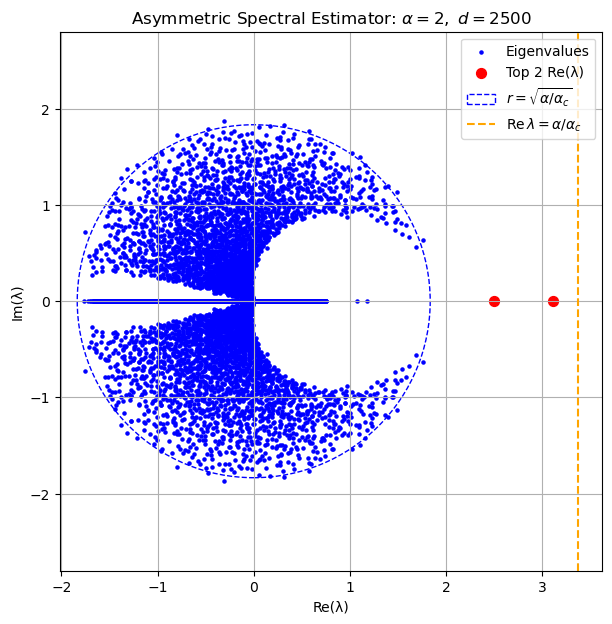

In [1]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# 固定随机种子（可复现性）
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# 配置参数
n = 5000  # 样本数
p = 2      # 子空间维度
alpha = 2
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: 生成输入矩阵 X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Step 2: 构造信号子空间 W* 和观测 Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link function: y = z1 * z2

# Step 3: 计算预处理函数 G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # 数值稳定处理

# 构造 G(y): 每个样本一个 2x2 对称矩阵
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Step 4: 构造非对称谱矩阵 L ∈ ℝ^{np × np}
XXT = X @ X.T  # shape: (n, n)
XXT.fill_diagonal_(0.0)  # 去掉主对角线

# 构造谱矩阵 L 的 (iμ, jν) 元素
A = XXT[:, :, None, None]            # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]     # shape: (1, n, p, p)
L_blocks = A * G_broadcast           # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # shape: (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Step 5: 计算特征值（在 GPU 上）并绘图
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# 获取最大两个实部的特征值索引和特征值
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# 可视化谱图
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# 理论谱圆半径和跳跃阈值
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# 图形设置
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


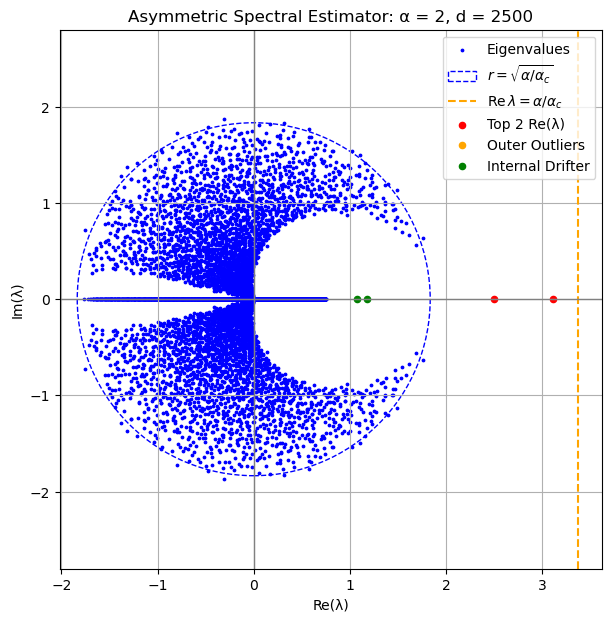

In [5]:
# 计算判定边界
R = np.sqrt(alpha / alpha_c)        # 蓝色圆圈的半径
thresh_ext = alpha / alpha_c        # 橙色虚线的位置

# 判断是否为实轴特征值
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# 选出前10个最大 Re(λ) 的实数特征值
top10_real_idx = np.argsort(real_parts)[-10:]
top10_real_vals = eigvals_real_only[top10_real_idx]

# 分类：红色（前2），橙色（落在外部圆环与虚线之间），绿色（内部漂移点）
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

# === 红点：前两个最大实部 ===
red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]

# === 橙点：在圆圈外，实部为正，且不在红点中 ===
orange_candidates = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
orange_vals = [z for z in orange_candidates if z not in red_vals]

# === 绿点：实轴且圆圈内，取实部最大前两个 ===
green_candidates = [z for z in eigvals_np 
                    if np.isclose(z.imag, 0.0, atol=1e-6) and abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# 绘图
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# 虚线：蓝色圆 & 橙色阈值线
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# 分类高亮
plt.scatter([z.real for z in top2_vals], [z.imag for z in top2_vals], color="red", s=20, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=20, label="Outer Outliers")
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=20, label="Internal Drifter")

# 画图设置
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


## 正确计算并且调用三个颜色的特征值点

In [19]:
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd


def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    """
    修正后的 generalized overlap 计算方法
    W_star: (d, 2)
    eigvals_np: (n*p,)
    eigvecs_np: (n*p, n*p)
    target_vals: List[complex]
    X: torch.Tensor (n, d)
    """
    results = []
    d = W_star.shape[0]

    # 正交化 W_star → 得到正交基 W_orth
    W_orth, _ = qr(W_star, mode='economic')  # shape: (d, 2)

    # 搬到 CPU
    X_cpu = X.cpu().numpy().T  # 变成 (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))  # 找到最近的特征值索引
        v_hat = eigvecs_np[:, idx]  # shape: (n*p, )
        V = v_hat.reshape(-1, 2)    # reshape 成 (n, p=2)

        U = X_cpu @ V  # shape: (d, p)
        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

W_star_np = W_star.cpu().numpy()

results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)


In [20]:
# === Step 1: 正确计算三个颜色方向的 overlap ===
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_orange = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# === Step 2: 合并为 df_result 并排序 ===
all_results = results_red + results_orange + results_green
df_result = pd.DataFrame(sorted(all_results, key=lambda x: -x[2]),
                         columns=["Label", "Eigenvalue", "Overlap_q"])


In [23]:
# ===============================
# 计算 overlap
# ===============================
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_orange = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X)

results_green = []
if green_vals is not None:
    results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# 合并所有结果
df_overlap = pd.DataFrame(results_red + results_orange + results_green,
                          columns=["Label", "Eigenvalue", "Overlap_q"])
df_overlap = df_overlap.sort_values("Overlap_q", ascending=False).reset_index(drop=True)

print(df_overlap)

      Label          Eigenvalue  Overlap_q
0  Green2-2  1.076215+0.000000j   0.219247
1  Green2-1  1.076215+0.000000j   0.219247
2  Green1-2  1.178461+0.000000j   0.200001
3  Green1-1  1.178461+0.000000j   0.200001
4    Red2-1  2.500422+0.000000j   0.168073
5    Red2-2  2.500422+0.000000j   0.168073
6    Red1-1  3.116228+0.000000j   0.159235
7    Red1-2  3.116228+0.000000j   0.159235


In [25]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# === 第二步：定义 rank-2 overlap 计算函数（不使用 Pt 编号）===
def rank2_overlap_from_labels(W_star, eigvals_np, eigvecs_np, df_result, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T  # shape (d, n)

    v_map = {}  # Label -> 向量

    for i, row in enumerate(df_result.itertuples()):
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # shape: (n, 2)
        j = 0 if '1' in label[-3:] else 1  # 通过 Label 末尾判断是第1还是第2个方向
        v_map[label] = V[:, j]

    # 枚举所有不重复组合
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # shape (d, 2)
        U, _ = qr(U, mode='economic')  # orthonormalize
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2  # Frobenius norm squared
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"])\
             .sort_values("Rank2_Overlap_q", ascending=False)\
             .reset_index(drop=True)


# === 第三步：调用函数 ===
# 假设以下变量已存在：
# - W_star_np: (d, 2)
# - eigvals_np, eigvecs_np: 特征值与特征向量（来自 torch）
# - df_result: 包含单点标签 ["Label", "Eigenvalue", "Overlap_q"]
# - X: 输入矩阵 (n, d)

df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_overlap, X)

# === 第四步：输出结果 ===
pd.set_option("display.max_rows", None)
print(df_rank2)


             ComboLabel  Rank2_Overlap_q
0   Green2-2 + Green1-1         0.419992
1   Green2-2 + Green1-2         0.419992
2   Green2-1 + Green1-2         0.419992
3   Green2-1 + Green1-1         0.419992
4     Green2-2 + Red2-2         0.388086
5     Green2-2 + Red2-1         0.388086
6     Green2-1 + Red2-2         0.388086
7     Green2-1 + Red2-1         0.388086
8     Green1-1 + Red1-2         0.359817
9     Green1-2 + Red1-1         0.359817
10    Green1-1 + Red1-1         0.359817
11    Green1-2 + Red1-2         0.359817
12      Red2-2 + Red1-1         0.328086
13      Red2-2 + Red1-2         0.328086
14      Red2-1 + Red1-2         0.328086
15      Red2-1 + Red1-1         0.328086
16  Green2-2 + Green2-1         0.263509
17    Green2-2 + Red1-2         0.224796
18    Green2-2 + Red1-1         0.224796
19    Green2-1 + Red1-2         0.224796
20    Green2-1 + Red1-1         0.224796
21  Green1-2 + Green1-1         0.201252
22    Green1-2 + Red2-1         0.201212
23    Green1-1 +

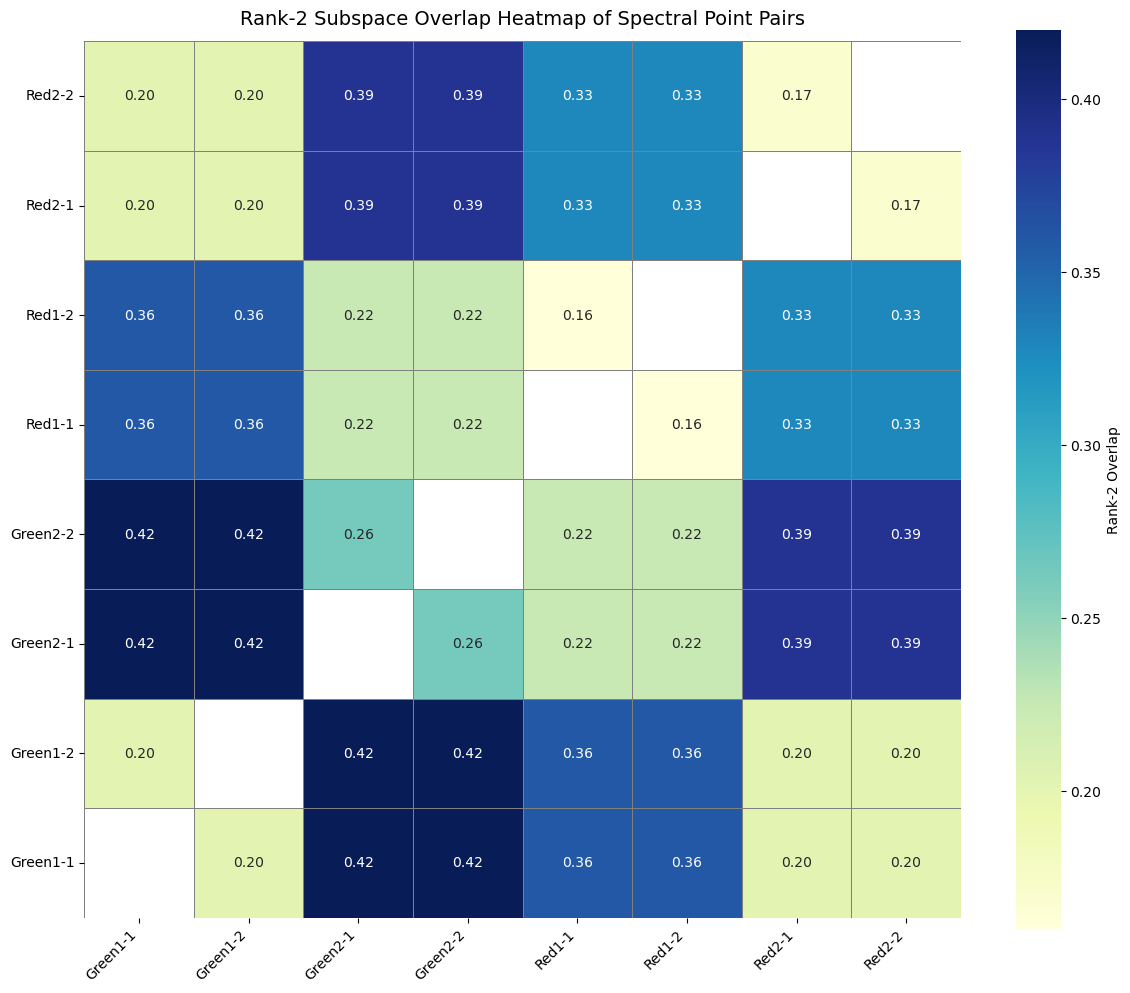

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import re

# === Step 1: 构建排序函数 ===
def custom_sort_key(label):
    try:
        color = "green" if label.lower().startswith("green") else "red"
        nums = re.findall(r'\d+', label)  # 提取所有数字
        if len(nums) < 2:
            raise ValueError(f"Label format error: {label}")
        return (0 if color == "green" else 1, int(nums[0]), int(nums[1]))
    except Exception as e:
        print(f"[Label Sorting Error] {label}: {e}")
        return (999, 999, 999)

# === Step 2: 提取所有唯一点名并排序 ===
all_labels = sorted(
    set(sum([label.split(' + ') for label in df_rank2['ComboLabel'] if isinstance(label, str)], [])),
    key=custom_sort_key
)

# === Step 3: 创建空对称矩阵 ===
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# === Step 4: 填入 Rank2 Overlap 值 ===
for _, row in df_rank2.iterrows():
    if isinstance(row['ComboLabel'], str) and ' + ' in row['ComboLabel']:
        a, b = row['ComboLabel'].split(' + ')
        heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
        heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# 对角线不绘制
np.fill_diagonal(heatmap_matrix.values, np.nan)

# === Step 5: 找出 Top-5 的组合 ===
top5 = df_rank2.nlargest(5, 'Rank2_Overlap_q')

# === Step 6: 绘制热力图 ===
plt.figure(figsize=(12, 10))
ax = sns.heatmap(heatmap_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True,
                 cbar_kws={'label': 'Rank-2 Overlap'}, linewidths=0.5, linecolor='gray')

plt.title("Rank-2 Subspace Overlap Heatmap of Spectral Point Pairs", fontsize=14, pad=12)



# 坐标轴设置
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax.invert_yaxis()

# 紧凑布局
plt.tight_layout()
plt.show()


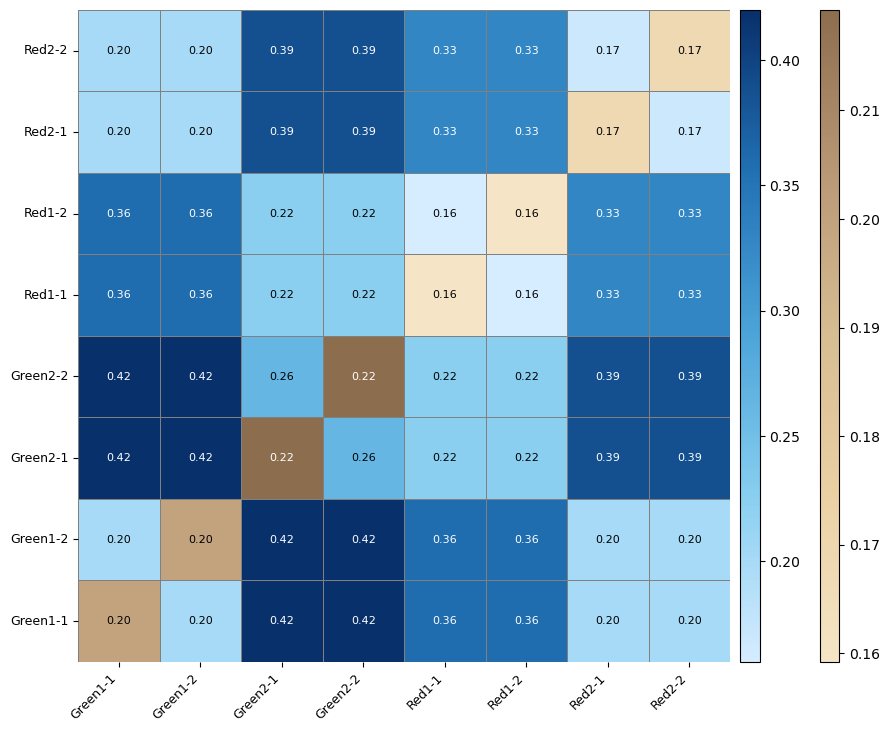

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# === Step 1: 统一标签来源 ===
labels_rank1 = set(df_result["Label"])
labels_rank2 = set()
for combo in df_rank2["ComboLabel"]:
    a, b = combo.split(" + ")
    labels_rank2.add(a)
    labels_rank2.add(b)

# 合并所有标签
all_labels = sorted(labels_rank1.union(labels_rank2))

# === Step 2: 按组排序（红→橙→绿） ===
color_order = ["Green", "Orange","Red"]
sorted_labels = []

for color in color_order:
    group = [label for label in all_labels if color.lower() in label.lower()]
    sorted_labels.extend(sorted(group))  # 可按自然排序优化

# === Step 3: 构建空矩阵 ===
heatmap_matrix = pd.DataFrame(np.nan, index=sorted_labels, columns=sorted_labels)

# === Step 4: 填入 Rank-2 数据 ===
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    if a in heatmap_matrix.index and b in heatmap_matrix.columns:
        heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
        heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# === Step 5: 填入 Rank-1 数据 ===
for _, row in df_result.iterrows():
    label = row['Label']
    if label in heatmap_matrix.index:
        heatmap_matrix.loc[label, label] = row['Overlap_q']

# === Step 6: 构造 mask 和 annot ===
mask_rank1 = ~np.eye(len(sorted_labels), dtype=bool)
mask_rank2 = np.eye(len(sorted_labels), dtype=bool)

# === Step 7: 自定义色图 ===
cmap_rank2 = LinearSegmentedColormap.from_list("bright_blue_gradient", [
    "#D6ECFF", "#89CFF0", "#4CA5D9", "#2171B5", "#08306B"
])

cmap_rank1 = LinearSegmentedColormap.from_list("custom_rank1_softbrown", [
    "#F5E5C6", "#EBD0A4", "#D7BD92", "#B99876", "#8C6D4E"
])

# === Step 8: 色阶范围 ===
rank1_values = heatmap_matrix.values[np.eye(len(sorted_labels), dtype=bool)]
rank2_values = heatmap_matrix.values[~np.eye(len(sorted_labels), dtype=bool)]

rank1_min, rank1_max = np.nanmin(rank1_values), np.nanmax(rank1_values)
rank2_min, rank2_max = np.nanmin(rank2_values), np.nanmax(rank2_values)

# === Step 9: 自动字体颜色 ===
def get_text_color(value, cmap, vmin, vmax):
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

# === Step 10: 绘制热力图 ===
fig, ax = plt.subplots(figsize=(9, 8))

# Rank-2 热图（蓝）
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank2,
    cmap=cmap_rank2,
    annot=False,
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# Rank-1 热图（棕）
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank1,
    cmap=cmap_rank1,
    annot=False,
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# 添加文字注释
for i in range(len(sorted_labels)):
    for j in range(len(sorted_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                ha='center', va='center', color=color, fontsize=8)

# === Step 11: 添加双色 colorbar ===
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)

sm1 = ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max))
sm1.set_array([])
fig.colorbar(sm1, cax=cax1)

sm2 = ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max))
sm2.set_array([])
fig.colorbar(sm2, cax=cax2)

# === Step 12: 美化坐标 ===
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [165]:
print("df_result 包含的标签：")
print(sorted(df_result["Label"].values))

print("df_rank2 ComboLabel 中出现的标签：")
labels_rank2_check = set()
for combo in df_rank2["ComboLabel"]:
    a, b = combo.split(" + ")
    labels_rank2_check.update([a, b])
print(sorted(labels_rank2_check))


df_result 包含的标签：
['Green1-1', 'Green1-2', 'Green2-1', 'Green2-2', 'Green3-1', 'Green3-2', 'Orange1-1', 'Orange1-2', 'Red1-1', 'Red1-2', 'Red2-1', 'Red2-2']
df_rank2 ComboLabel 中出现的标签：
['Green1-1', 'Green1-2', 'Green2-1', 'Green2-2', 'Green3-1', 'Green3-2', 'Orange1-1', 'Orange1-2', 'Red1-1', 'Red1-2', 'Red2-1', 'Red2-2']


In [173]:
# === 计算所有方向的 Rank-1 overlap ===
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_orange = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X)

results_green = []
if green_vals is not None:
    results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# === 合并为 DataFrame 供热力图使用 ===
df_result = pd.DataFrame(
    results_red + results_orange + results_green,
    columns=["Label", "Eigenvalue", "Overlap_q"]
)


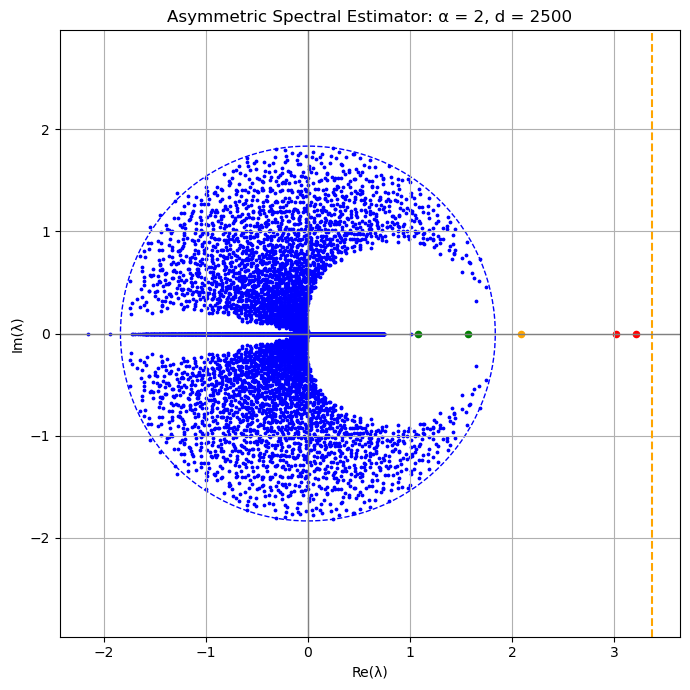

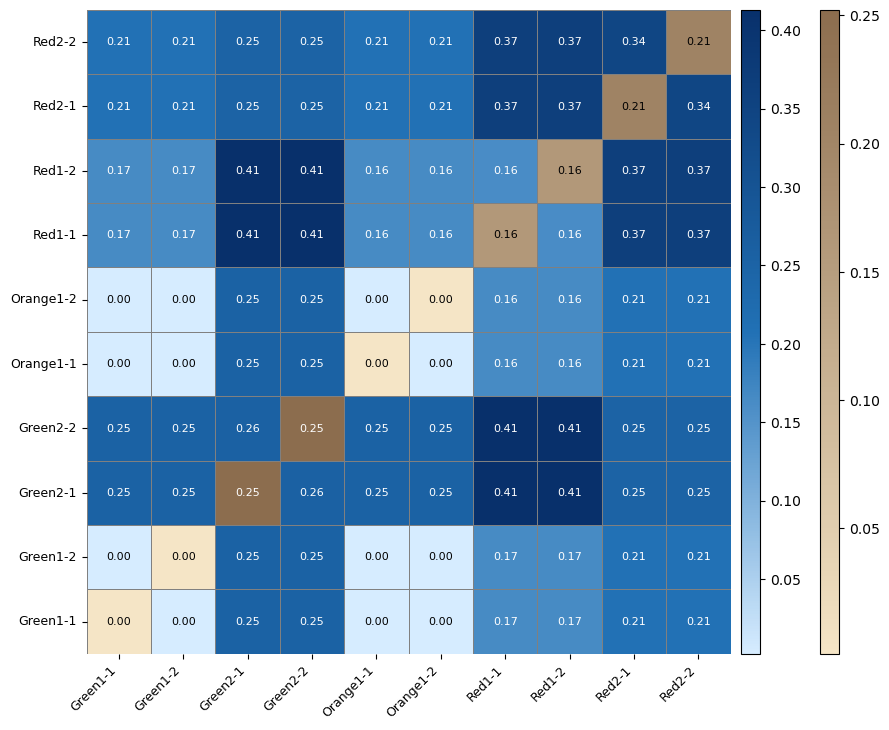

In [57]:
# === 核心依赖 ===
import os
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.linalg import qr
from scipy.special import kv as besselk
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable


# ========== Step 0: 工具函数 ==========
def set_seed(seed=44):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)


def get_text_color(value, cmap, vmin, vmax):
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'


from numpy.linalg import norm
from scipy.linalg import qr

def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    """
    正确计算与真实子空间的 Rank-1 对齐得分（单位向量投影长度的平方）
    """
    results = []
    d = W_star.shape[0]

    # 正交化 W_star
    W_orth, _ = qr(W_star, mode='economic')  # (d, 2)

    X_cpu = X.cpu().numpy().T  # (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))  # 最近特征值索引
        v_hat = eigvecs_np[:, idx]  # (n*p, )
        V = v_hat.reshape(-1, 2)    # (n, p)

        U = X_cpu @ V               # (d, p)
        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            # 投影得分：u_hat 在 W_orth 子空间上的投影范数平方（∈ [0,1]）
            q = norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results



def rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X):
    results = []
    W_orth, _ = qr(W_star_np, mode='economic')
    X_cpu = X.cpu().numpy().T
    v_map = {}
    for row in df_result.itertuples():
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx].reshape(-1, 2)
        j = 0 if '1' in label[-3:] else 1
        v_map[label] = v_hat[:, j]
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])
        U, _ = qr(U, mode='economic')
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2
        results.append((f"{id1} + {id2}", q))
    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False).reset_index(drop=True)


# ========== Step 1: 参数设置 ==========
set_seed(44)
n, p = 5000, 2
alpha, alpha_c = 2, 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Step 2: 数据生成 ==========
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2

# G(y)
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1, K0 = besselk(1, abs_y), besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# ========== Step 3: 构造谱矩阵 ==========
XXT = X @ X.T
XXT.fill_diagonal_(0.0)
A = XXT[:, :, None, None]
G_broadcast = G_y[None, :, :, :]
L_blocks = A * G_broadcast
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

# ========== Step 4: 谱分解与分类 ==========
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvecs_np = eigvecs.detach().cpu().numpy()
W_star_np = W_star.cpu().numpy()

real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c

red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]
orange_candidates = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
orange_vals = [z for z in orange_candidates if z not in red_vals]
green_candidates = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6) and abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# ========== Step 5: 可视化谱图 ==========
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3)
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False)
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--")
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=30)
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=30)
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=30)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()

# ========== Step 6: 计算 overlap ==========
df_result = pd.DataFrame(
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X),
    columns=["Label", "Eigenvalue", "Overlap_q"]
).sort_values("Overlap_q", ascending=False).reset_index(drop=True)

# ========== Step 7: Rank-2 overlap ==========
df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)

# ========== Step 8: 绘制热力图 ==========
labels_rank1 = set(df_result["Label"])
labels_rank2 = set()
for combo in df_rank2["ComboLabel"]:
    a, b = combo.split(" + ")
    labels_rank2.update([a, b])

all_labels = sorted(labels_rank1.union(labels_rank2))
color_order = ["Green", "Orange", "Red"]
sorted_labels = []
for color in color_order:
    sorted_labels.extend(sorted([l for l in all_labels if color.lower() in l.lower()]))

heatmap_matrix = pd.DataFrame(np.nan, index=sorted_labels, columns=sorted_labels)
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']
for _, row in df_result.iterrows():
    heatmap_matrix.loc[row['Label'], row['Label']] = row['Overlap_q']

# 自定义色图
cmap_rank2 = LinearSegmentedColormap.from_list("blue_grad", ["#D6ECFF", "#2171B5", "#08306B"])
cmap_rank1 = LinearSegmentedColormap.from_list("brown_grad", ["#F5E5C6", "#8C6D4E"])
rank1_vals = heatmap_matrix.values[np.eye(len(sorted_labels), dtype=bool)]
rank2_vals = heatmap_matrix.values[~np.eye(len(sorted_labels), dtype=bool)]
rank1_min, rank1_max = np.nanmin(rank1_vals), np.nanmax(rank1_vals)
rank2_min, rank2_max = np.nanmin(rank2_vals), np.nanmax(rank2_vals)

# 绘图
fig, ax = plt.subplots(figsize=(9, 8))
mask_rank1 = ~np.eye(len(sorted_labels), dtype=bool)
mask_rank2 = np.eye(len(sorted_labels), dtype=bool)

sns.heatmap(heatmap_matrix, mask=mask_rank2, cmap=cmap_rank2, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)
sns.heatmap(heatmap_matrix, mask=mask_rank1, cmap=cmap_rank1, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)

# 添加注释
for i in range(len(sorted_labels)):
    for j in range(len(sorted_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", ha='center', va='center', color=color, fontsize=8)

# 添加 colorbar
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)
fig.colorbar(ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max)), cax=cax1)
fig.colorbar(ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max)), cax=cax2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


# ========== Step 9: 打印评估指标 ==========

# Rank-1 Overlap 评估
print("\n=== Rank-1 Overlap Summary ===")
top_rank1 = df_result.sort_values("Overlap_q", ascending=False)
print(top_rank1[["Label", "Overlap_q"]].to_string(index=False))
print(f"\nMean: {df_result['Overlap_q'].mean():.4f} | "
      f"Max: {df_result['Overlap_q'].max():.4f} | "
      f"Min: {df_result['Overlap_q'].min():.4f}")

# Rank-2 Overlap 评估
print("\n=== Rank-2 Overlap Summary ===")
top_rank2 = df_rank2.sort_values("Rank2_Overlap_q", ascending=False)
print("Top 5:\n", top_rank2[["ComboLabel", "Rank2_Overlap_q"]].to_string(index=False))
print(f"\nMean: {df_rank2['Rank2_Overlap_q'].mean():.4f} | "
      f"Max: {df_rank2['Rank2_Overlap_q'].max():.4f} | "
      f"Min: {df_rank2['Rank2_Overlap_q'].min():.4f}")


In [63]:
# ========== Step 9: 打印评估指标 ==========

# Rank-1 Overlap 评估
print("\n=== Rank-1 Overlap Summary ===")
top_rank1 = df_result.sort_values("Overlap_q", ascending=False)
print(top_rank1[["Label", "Overlap_q"]].to_string(index=False))
print(f"\nMean: {df_result['Overlap_q'].mean():.4f} | "
      f"Max: {df_result['Overlap_q'].max():.4f} | "
      f"Min: {df_result['Overlap_q'].min():.4f}")

# Rank-2 Overlap 评估
print("\n=== Rank-2 Overlap Summary ===")
top_rank2 = df_rank2.sort_values("Rank2_Overlap_q", ascending=False)
print("Top 5:\n", top_rank2[["ComboLabel", "Rank2_Overlap_q"]].to_string(index=False))
print(f"\nMean: {df_rank2['Rank2_Overlap_q'].mean():.4f} | "
      f"Max: {df_rank2['Rank2_Overlap_q'].max():.4f} | "
      f"Min: {df_rank2['Rank2_Overlap_q'].min():.4f}")



=== Rank-1 Overlap Summary ===
    Label  Overlap_q
 Green2-2   0.252180
 Green2-1   0.252179
   Red2-1   0.205490
   Red2-2   0.205489
   Red1-1   0.161374
   Red1-2   0.161374
Orange1-2   0.001412
Orange1-1   0.001412
 Green1-2   0.001108
 Green1-1   0.001108

Mean: 0.1243 | Max: 0.2522 | Min: 0.0011

=== Rank-2 Overlap Summary ===
Top 5:
            ComboLabel  Rank2_Overlap_q
    Green2-1 + Red1-1         0.413100
    Green2-1 + Red1-2         0.413100
    Green2-2 + Red1-1         0.413100
    Green2-2 + Red1-2         0.413100
      Red2-2 + Red1-2         0.366353
      Red2-2 + Red1-1         0.366353
      Red2-1 + Red1-2         0.366353
      Red2-1 + Red1-1         0.366353
      Red2-1 + Red2-2         0.343781
  Green2-2 + Green2-1         0.258017
 Green2-1 + Orange1-2         0.253570
 Green2-1 + Orange1-1         0.253570
 Green2-2 + Orange1-2         0.253570
 Green2-2 + Orange1-1         0.253570
  Green2-1 + Green1-2         0.253309
  Green2-1 + Green1-1         0

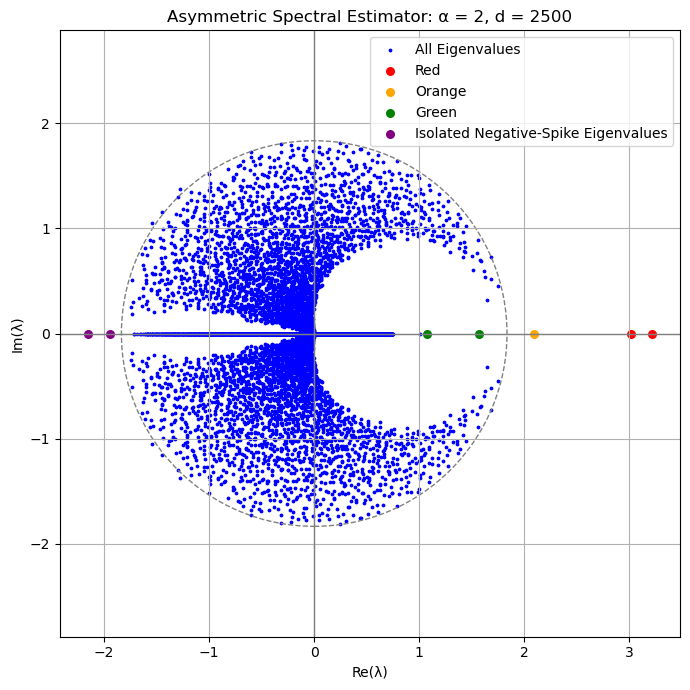


=== Rank-1 Overlap Summary ===
        Label  Overlap_q
0    Green2-2   0.252180
1    Green2-1   0.252179
2      Red2-1   0.205490
3      Red2-2   0.205489
4      Red1-1   0.161374
5      Red1-2   0.161374
6   Orange1-2   0.001412
7   Orange1-1   0.001412
8   Purple2-1   0.001311
9   Purple2-2   0.001311
10   Green1-2   0.001108
11   Green1-1   0.001108
12  Purple1-2   0.000051
13  Purple1-1   0.000051
Mean: 0.0890 | Max: 0.2522 | Min: 0.0001

=== Top 10 Rank-2 Overlap Combinations ===
            ComboLabel  Rank2_Overlap_q
0    Green2-1 + Red1-1         0.413100
1    Green2-1 + Red1-2         0.413100
2    Green2-2 + Red1-1         0.413100
3    Green2-2 + Red1-2         0.413100
4      Red2-2 + Red1-2         0.366353
5      Red2-2 + Red1-1         0.366353
6      Red2-1 + Red1-2         0.366353
7      Red2-1 + Red1-1         0.366353
8      Red2-1 + Red2-2         0.343781
9  Green2-2 + Green2-1         0.258017


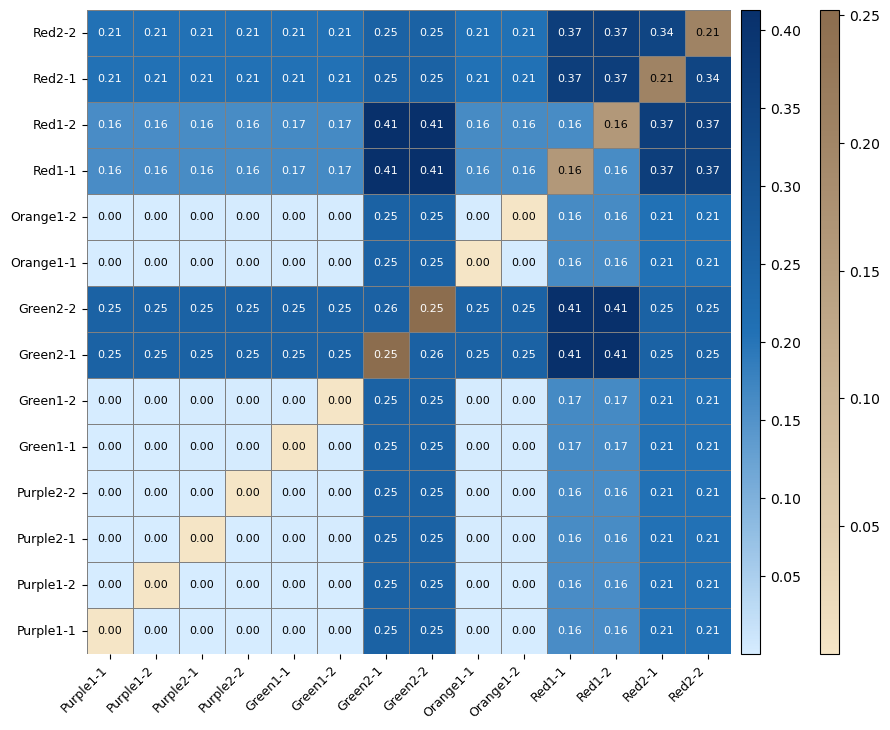

In [67]:
# === 依赖导入 ===
import os, random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.linalg import qr
from scipy.special import kv as besselk
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# === 工具函数 ===
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_text_color(value, cmap, vmin, vmax):
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T
    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)
        U = X_cpu @ V
        for j in range(2):
            u = U[:, j]
            u_hat = u / np.linalg.norm(u)
            q = np.linalg.norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

def rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X):
    results = []
    W_orth, _ = qr(W_star_np, mode='economic')
    X_cpu = X.cpu().numpy().T
    v_map = {}
    for row in df_result.itertuples():
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx].reshape(-1, 2)
        j = 0 if '1' in label[-3:] else 1
        v_map[label] = v_hat[:, j]
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])
        U, _ = qr(U, mode='economic')
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2
        results.append((f"{id1} + {id2}", q))
    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False).reset_index(drop=True)

# === 参数设置 ===
set_seed(44)
n, p = 5000, 2
alpha, alpha_c = 2, 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 数据生成 ===
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2

# === 构造 G(y) 矩阵 ===
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1, K0 = besselk(1, abs_y), besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# === 构造谱矩阵 ===
XXT = X @ X.T
XXT.fill_diagonal_(0.0)
A = XXT[:, :, None, None]
G_broadcast = G_y[None, :, :, :]
L_blocks = A * G_broadcast
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

# === 谱分解与分类 ===
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

R = np.sqrt(alpha / alpha_c)
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real = eigvals_np[real_mask]

red_vals = sorted(eigvals_real, key=lambda z: z.real, reverse=True)[:2]
orange_vals = [z for z in eigvals_real if abs(z) > R and z.real > 0 and z not in red_vals]
green_vals = sorted([z for z in eigvals_real if abs(z) <= R and z.real > 0], key=lambda z: z.real, reverse=True)[:2]
purple_vals = [z for z in eigvals_real if z.real < 0 and abs(z) > R]

# === 谱图绘制 ===
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="All Eigenvalues")
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=30, label="Red")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=30, label="Orange")
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=30, label="Green")
plt.scatter([z.real for z in purple_vals], [z.imag for z in purple_vals], color="purple", s=30, label="Isolated Negative-Spike Eigenvalues")

circle = plt.Circle((0, 0), R, color="gray", linestyle="--", fill=False)
plt.gca().add_artist(circle)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()

# === 计算 overlap 并打印 ===
df_result = pd.DataFrame(
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, purple_vals, "Purple", X),
    columns=["Label", "Eigenvalue", "Overlap_q"]
).sort_values("Overlap_q", ascending=False).reset_index(drop=True)

print("\n=== Rank-1 Overlap Summary ===")
print(df_result[["Label", "Overlap_q"]])
print(f"Mean: {df_result['Overlap_q'].mean():.4f} | Max: {df_result['Overlap_q'].max():.4f} | Min: {df_result['Overlap_q'].min():.4f}")

# === Rank-2 overlap ===
df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)
print("\n===  Rank-2 Overlap Combinations ===")
print(df_rank2)

# === 热力图绘制 ===
labels_rank1 = set(df_result["Label"])
labels_rank2 = set()
for combo in df_rank2["ComboLabel"]:
    a, b = combo.split(" + ")
    labels_rank2.update([a, b])
all_labels = sorted(labels_rank1.union(labels_rank2))
color_order = [ "Purple","Green", "Orange", "Red"]
sorted_labels = []
for color in color_order:
    sorted_labels.extend(sorted([l for l in all_labels if color.lower() in l.lower()]))

heatmap_matrix = pd.DataFrame(np.nan, index=sorted_labels, columns=sorted_labels)
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']
for _, row in df_result.iterrows():
    heatmap_matrix.loc[row['Label'], row['Label']] = row['Overlap_q']

cmap_rank2 = LinearSegmentedColormap.from_list("blue_grad", ["#D6ECFF", "#2171B5", "#08306B"])
cmap_rank1 = LinearSegmentedColormap.from_list("brown_grad", ["#F5E5C6", "#8C6D4E"])
rank1_vals = heatmap_matrix.values[np.eye(len(sorted_labels), dtype=bool)]
rank2_vals = heatmap_matrix.values[~np.eye(len(sorted_labels), dtype=bool)]
rank1_min, rank1_max = np.nanmin(rank1_vals), np.nanmax(rank1_vals)
rank2_min, rank2_max = np.nanmin(rank2_vals), np.nanmax(rank2_vals)

fig, ax = plt.subplots(figsize=(9, 8))
mask_rank1 = ~np.eye(len(sorted_labels), dtype=bool)
mask_rank2 = np.eye(len(sorted_labels), dtype=bool)

sns.heatmap(heatmap_matrix, mask=mask_rank2, cmap=cmap_rank2, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)
sns.heatmap(heatmap_matrix, mask=mask_rank1, cmap=cmap_rank1, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)

for i in range(len(sorted_labels)):
    for j in range(len(sorted_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", ha='center', va='center', color=color, fontsize=8)

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)
fig.colorbar(ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max)), cax=cax1)
fig.colorbar(ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max)), cax=cax2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [135]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# === 第二步：定义 rank-2 overlap 计算函数（不使用 Pt 编号）===
def rank2_overlap_from_labels(W_star, eigvals_np, eigvecs_np, df_overlap, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T  # shape (d, n)

    v_map = {}  # Label -> 向量

    for i, row in enumerate(df_result.itertuples()):
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # shape: (n, 2)
        j = 0 if '1' in label[-3:] else 1  # 通过 Label 末尾判断是第1还是第2个方向
        v_map[label] = V[:, j]

    # 枚举所有不重复组合
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # shape (d, 2)
        U, _ = qr(U, mode='economic')  # orthonormalize
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2  # Frobenius norm squared
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"])\
             .sort_values("Rank2_Overlap_q", ascending=False)\
             .reset_index(drop=True)


# === 第三步：调用函数 ===
# 假设以下变量已存在：
# - W_star_np: (d, 2)
# - eigvals_np, eigvecs_np: 特征值与特征向量（来自 torch）
# - df_result: 包含单点标签 ["Label", "Eigenvalue", "Overlap_q"]
# - X: 输入矩阵 (n, d)

df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)

# === 第四步：输出结果 ===
pd.set_option("display.max_rows", None)
print(df_rank2)


             ComboLabel  Rank2_Overlap_q
0   Green2-1 + Green3-2           0.4891
1   Green2-1 + Green3-1           0.4891
2   Green2-2 + Green3-1           0.4891
3   Green2-2 + Green3-2           0.4891
4     Green3-2 + Red2-1           0.4423
5     Green3-2 + Red2-2           0.4423
6     Green3-1 + Red2-2           0.4423
7     Green3-1 + Red2-1           0.4423
8     Green2-1 + Red1-2           0.4131
9     Green2-1 + Red1-1           0.4131
10    Green2-2 + Red1-1           0.4131
11    Green2-2 + Red1-2           0.4131
12      Red2-1 + Red1-2           0.3664
13      Red2-2 + Red1-2           0.3664
14      Red2-1 + Red1-1           0.3664
15      Red2-2 + Red1-1           0.3664
16      Red2-1 + Red2-2           0.3438
17  Green2-2 + Green2-1           0.2580
18  Green2-1 + Green1-2           0.2533
19  Green2-1 + Green1-1           0.2533
20  Green2-2 + Green1-1           0.2533
21  Green2-2 + Green1-2           0.2533
22    Green2-1 + Red2-1           0.2523
23    Green2-1 +

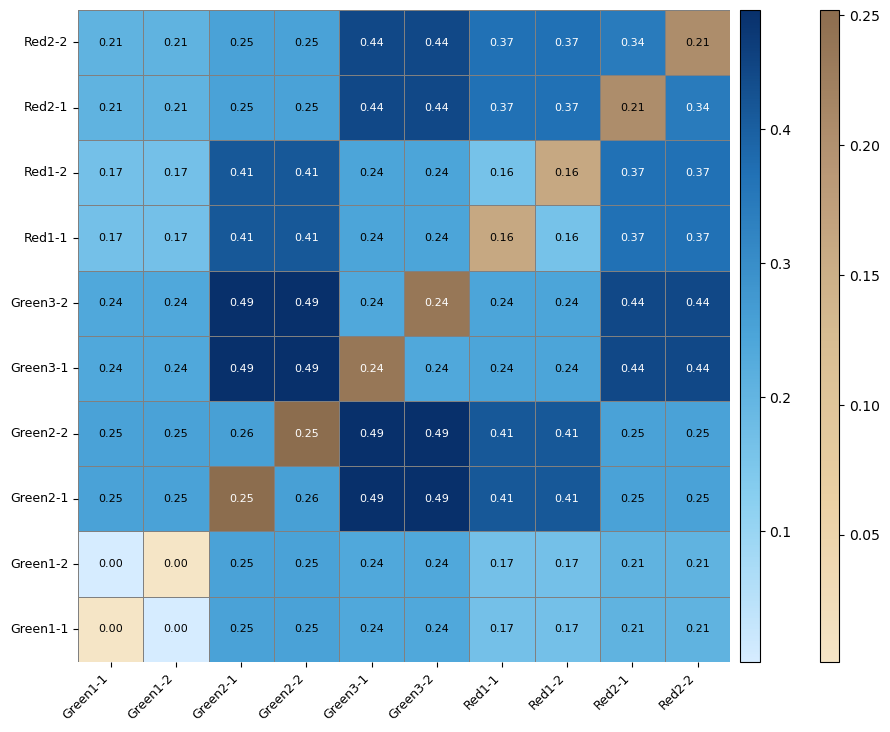

In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# === Step 1: 构建矩阵 ===
all_labels = sorted(set(df_result["Label"]))
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

for _, row in df_result.iterrows():
    label = row['Label']
    heatmap_matrix.loc[label, label] = row['Overlap_q']

# === Step 2: 构造 mask 和 annot ===
mask_rank1 = ~np.eye(len(all_labels), dtype=bool)
mask_rank2 = np.eye(len(all_labels), dtype=bool)

annot_matrix_rank1 = heatmap_matrix.where(~mask_rank1).round(2).astype(str).mask(mask_rank1, "")
annot_matrix_rank2 = heatmap_matrix.where(~mask_rank2).round(2).astype(str).mask(mask_rank2, "")

# === Step 3: 自定义 colormap ===
# 蓝色渐变（Rank-2）
cmap_rank2 = LinearSegmentedColormap.from_list("bright_blue_gradient", [
    "#D6ECFF",  # 极浅蓝（几乎白蓝过渡）
    "#89CFF0",  # 宝宝蓝（清新专业）
    "#4CA5D9",  # 主体蓝色（明亮）
    "#2171B5",  # 稍深蓝
    "#08306B"   # 压轴深蓝
])

# 色值列表从浅到深（棕色系）
cmap_rank1 = LinearSegmentedColormap.from_list("custom_rank1_softbrown", [
    "#F5E5C6",  # 浅奶茶
    "#EBD0A4",  # 米杏色
    "#D7BD92",  # 金棕色（中等）
    "#B99876",  # 柔和深杏
    "#8C6D4E"   # 稍暗但不沉
])

# === Step 4: 色阶范围 ===
rank1_values = heatmap_matrix.values[np.eye(len(all_labels), dtype=bool)]
rank2_values = heatmap_matrix.values[~np.eye(len(all_labels), dtype=bool)]

rank1_min, rank1_max = np.nanmin(rank1_values), np.nanmax(rank1_values)
rank2_min, rank2_max = np.nanmin(rank2_values), np.nanmax(rank2_values)

# === Step 5: 白/黑字体判断函数 ===
def get_text_color(value, cmap, vmin, vmax):
    """根据背景亮度自动设置文字为黑色或白色"""
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

# === Step 6: 绘图 ===
fig, ax = plt.subplots(figsize=(9, 8))

# 绘制背景蓝色（rank-2）
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank2,
    cmap=cmap_rank2,
    annot=False,
    fmt="",
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# 绘制背景橙色（rank-1）
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank1,
    cmap=cmap_rank1,
    annot=False,
    fmt="",
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# 添加数值文字（自动字体颜色）
for i in range(len(all_labels)):
    for j in range(len(all_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                ha='center', va='center', color=color, fontsize=8)

# === Step 7: 添加双色条 ===
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)

sm1 = ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max))
sm1.set_array([])
fig.colorbar(sm1, cax=cax1)

sm2 = ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max))
sm2.set_array([])
fig.colorbar(sm2, cax=cax2)

# === Step 8: 美化 ===

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


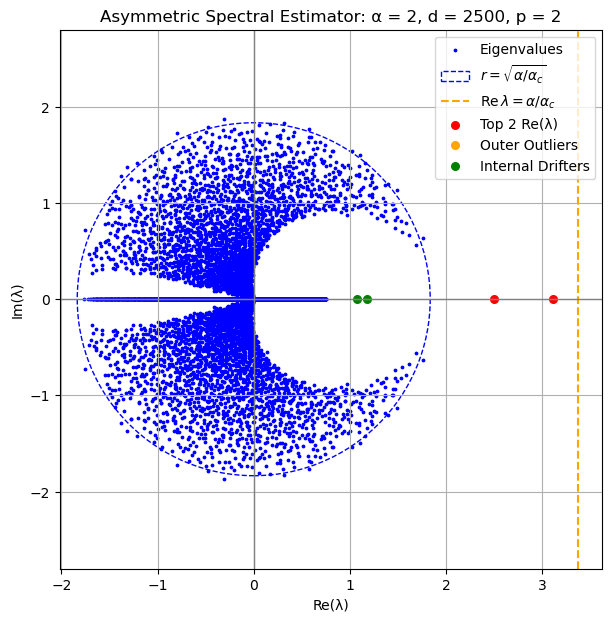


=== Alignment Score for Individual Eigenvalues ===
     Type                   λ  Alignment Score
0  Green1  1.178461+0.000000j         0.328646
1  Green2  1.076215+0.000000j         0.339109
2    Red1  3.116228+0.000000j         0.298271
3    Red2  2.500422+0.000000j         0.221658

=== Alignment Score for Pairs of Eigenvalues ===
            Pair                  λ1                  λ2  Alignment Score
3    Green2-Red1  1.076215+0.000000j  3.116228+0.000000j         0.339109
4    Green2-Red2  1.076215+0.000000j  2.500422+0.000000j         0.339109
0  Green1-Green2  1.178461+0.000000j  1.076215+0.000000j         0.328646
1    Green1-Red1  1.178461+0.000000j  3.116228+0.000000j         0.328646
2    Green1-Red2  1.178461+0.000000j  2.500422+0.000000j         0.328646
5      Red1-Red2  3.116228+0.000000j  2.500422+0.000000j         0.298271


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_23798/850667457.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


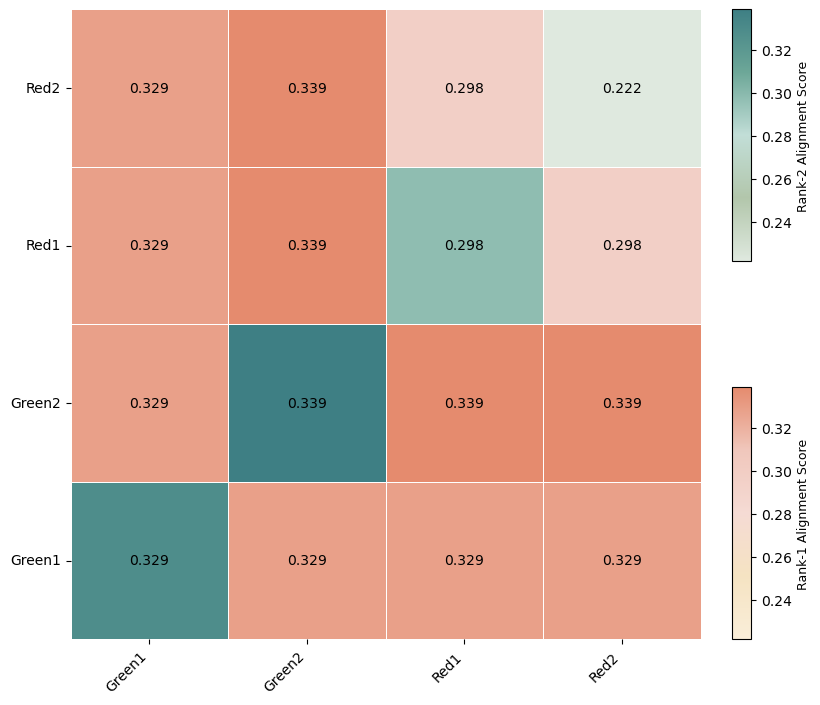

In [35]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations

# ========== 对齐度函数 ==========
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# ========== 子空间提取（单个特征值） ==========
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# ========== 子空间提取（特征值对组合） ==========
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# ========== 提取谱信息 ==========
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# ========== 分类特征值（红橙绿） ==========


# ==== 基础变量 ====
R = np.sqrt(alpha / alpha_c)  # 半径阈值
eigvals_np = eigvals.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]  # 只取实数谱点

# ==== 1. 红色点（Red）：半径外的前两个最大实部特征值 ====
outside_radius = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside_radius, key=lambda z: z.real, reverse=True)[:2]

# ==== 2. 橙色点（Orange）：半径外、非红色的其他正实数特征值 ====
orange_vals = [z for z in outside_radius if z not in red_vals]

# ==== 3. 绿色点（Green）：半径内、落在实数轴上的前 n 个实部最大的特征值 ====
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]  # 可改为 [:n]





# ========== 正确编号（每组内实部大的是1） ==========
green_vals_sorted = sorted(green_vals, key=lambda z: z.real, reverse=True)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals_sorted)]

orange_vals_sorted = sorted(orange_vals, key=lambda z: z.real, reverse=True)
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals_sorted)]

red_vals_sorted = sorted(red_vals, key=lambda z: z.real, reverse=True)
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals_sorted)]

# ========== 合并标签 ==========
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]  # Green1 Green2 Orange1 Orange2 Red1 Red2

# ========== 【一次性谱图绘制】 ==========
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# ========== Code 1：单点对齐得分 ==========
results_single = []
for label, z in all_labels:
    results_single.append(extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label))
df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# ========== Code 2：两两组合对齐得分 ==========
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label))
df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# ========== Code 3：热力图绘制 ==========


# ========== 创建热力图数据 ==========
# 初始化 DataFrame
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# 填入单点（对角线）得分
for _, row in df_single.iterrows():
    label = row["Type"]
    score = row["Alignment Score"]
    heatmap_df.loc[label, label] = score

# 填入两两组合（非对角线）得分
for _, row in df_pair.iterrows():
    label1, label2 = row["Pair"].split("-")
    score = row["Alignment Score"]
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score  # 对称填充

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



# 颜色列表
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)



# 创建 mask
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# 值范围
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# 创建图形
fig, ax = plt.subplots(figsize=(8, 7))

# plot1: off-diagonal（Rank-2）
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# 添加紧凑 colorbar
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right', bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
cbar1.set_label("Rank-2 Alignment Score", fontsize=9)

# plot2: diagonal（Rank-1）
sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# 添加第二个 colorbar
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right', bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
cbar2.set_label("Rank-1 Alignment Score", fontsize=9)

# 注释数值
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

# 美化

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)

plt.show()



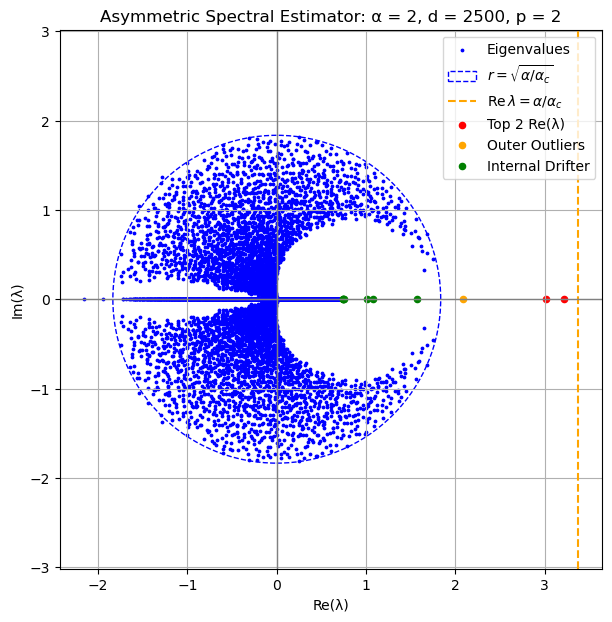

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# ===============================
# Overlap 计算函数
# ===============================
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # 正交化 W_star
    X_cpu = X.cpu().numpy().T  # 变为 shape (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]  # shape: (n*p,)
        V = v_hat.reshape(-1, 2)    # shape: (n, 2)

        U = X_cpu @ V  # shape: (d, 2)
        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

# ===============================
# 计算特征值与分类
# ===============================
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()


d = W_star_np.shape[0]

R = np.sqrt(alpha / alpha_c)        # 蓝色圆圈半径
thresh_ext = alpha / alpha_c        # 橙色虚线位置

# 实谱筛选
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Top 实部谱点选取
top10_real_idx = np.argsort(real_parts)[-10:]
top10_real_vals = eigvals_real_only[top10_real_idx]

# 分类
red_vals = top10_real_vals[-2:]
rest_vals = top10_real_vals[:-2]

orange_vals = []
green_vals = []
for val in rest_vals:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_vals.append(val)

# ===============================
# 可视化：带标注分类
# ===============================
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=20, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=20, label="Outer Outliers")
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=20, label="Internal Drifter")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# ===============================
# 计算每类谱点的 overlap（投影得分）
# ===============================
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_orange = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# 合并结果 & 输出表格
df_overlap = pd.DataFrame(results_red + results_orange + results_green,
                          columns=["Label", "Eigenvalue", "Overlap_q"])
df_overlap = df_overlap.sort_values("Overlap_q", ascending=False).reset_index(drop=True)

#

In [6]:
print(df_overlap.head(80))  # 打印前10个 overlap 最大的谱点


        Label          Eigenvalue  Overlap_q
0    Green6-2  1.075180+0.000000j   0.252180
1    Green6-1  1.075180+0.000000j   0.252179
2    Green5-1  1.011442+0.000000j   0.237310
3    Green5-2  1.011442+0.000000j   0.237310
4      Red1-1  3.019315+0.000000j   0.205490
5      Red1-2  3.019315+0.000000j   0.205489
6      Red2-1  3.213964+0.000000j   0.161374
7      Red2-2  3.213964+0.000000j   0.161374
8    Green1-1  0.741970+0.000000j   0.008887
9    Green1-2  0.741970+0.000000j   0.008845
10   Green2-2  0.742000+0.000000j   0.004449
11   Green2-1  0.742000+0.000000j   0.004374
12   Green4-1  0.747193+0.000000j   0.003528
13   Green4-2  0.747193+0.000000j   0.003528
14  Orange1-2  2.088642+0.000000j   0.001412
15  Orange1-1  2.088642+0.000000j   0.001412
16   Green7-2  1.565534+0.000000j   0.001108
17   Green7-1  1.565534+0.000000j   0.001108
18   Green3-1  0.744112+0.000000j   0.000418
19   Green3-2  0.744112+0.000000j   0.000417


In [7]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# === 输入部分：你需要确保这些变量事先定义好 ===
# W_star_np: numpy.ndarray, shape (d, 2)，目标信号子空间
# eigvals_np: numpy.ndarray, shape (n*p,), L 的特征值
# eigvecs_np: numpy.ndarray, shape (n*p, n*p), L 的特征向量
# red_vals, green_vals: List[complex], 红色/绿色谱点
# X: torch.Tensor, shape (n, d)，原始样本数据

# === 单点 overlap 表（你可以从已有代码或文件中加载） ===
# df_result: 包含 ["Label", "Eigenvalue", "Overlap_q"] 三列
# 下面用一个示例生成占位 df_result（实际替换为你的结果）：
# df_result = pd.read_csv("your_overlap_result.csv")
# 下面是占位数据，运行前请替换！
# df_result = your_overlap_dataframe

# === 第一步：构造 PtX-Y → Label 的映射 ===
pt_label_map = {}
for idx, row in enumerate(df_overlap.itertuples()):
    pt_id = f"Pt{idx // 2 + 1}-{idx % 2 + 1}"  # Pt1-1, Pt1-2 ...
    pt_label_map[pt_id] = row.Label

# === 第二步：定义 rank-2 overlap 函数 ===
def rank2_overlap_from_two_points_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # 正交化目标子空间
    X_cpu = X.cpu().numpy().T  # shape: (d, n)

    # 构造谱点对应的特征向量 v_map
    v_map = {}
    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))  # 最接近的特征值索引
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # shape: (n, 2)
        for j in range(2):
            tag = f"{label_prefix}{i+1}-{j+1}"
            v_map[tag] = V[:, j]

    # 枚举所有两两组合，计算其构成子空间与 W_star 的 overlap
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # shape: (d, 2)
        U, _ = qr(U, mode='economic')  # 正交化
        q = norm(W_orth.T @ U, ord='fro')**2  # Frobenius norm² 表示子空间恢复程度
        results.append((f"{id1} + {id2}", q))

    df = pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"])
    df = df.sort_values("Rank2_Overlap_q", ascending=False).reset_index(drop=True)
    return df

# === 第三步：调用函数，合并谱点列表 ===
target_vals = list(red_vals) + list(green_vals)
df_rank2 = rank2_overlap_from_two_points_corrected(
    W_star_np, eigvals_np, eigvecs_np, target_vals, label_prefix="Pt", X=X
)

# === 第四步：替换标签为真实语义标签 ===
def replace_combo_label(combo):
    id1, id2 = combo.split(" + ")
    return f"{pt_label_map.get(id1, id1)} + {pt_label_map.get(id2, id2)}"

df_rank2["ComboLabel"] = df_rank2["ComboLabel"].apply(replace_combo_label)

# === 第五步：输出或保存结果 ===
pd.set_option("display.max_rows", None)
print(df_rank2)

# 如需保存为 CSV：
# df_rank2.to_csv("rank2_overlap_results.csv", index=False)


                ComboLabel  Rank2_Overlap_q
0     Green4-2 + Orange1-1         0.489123
1     Green4-2 + Orange1-2         0.489123
2     Green4-1 + Orange1-1         0.489123
3     Green4-1 + Orange1-2         0.489123
4      Green6-2 + Green4-2         0.442347
5      Green6-2 + Green4-1         0.442347
6      Green6-1 + Green4-2         0.442347
7      Green6-1 + Green4-1         0.442347
8     Green5-2 + Orange1-1         0.413100
9     Green5-2 + Orange1-2         0.413100
10    Green5-1 + Orange1-2         0.413100
11    Green5-1 + Orange1-1         0.413100
12     Green6-1 + Green5-1         0.366353
13     Green6-2 + Green5-1         0.366353
14     Green6-2 + Green5-2         0.366352
15     Green6-1 + Green5-2         0.366352
16     Green6-2 + Green6-1         0.343781
17     Green5-1 + Green5-2         0.324023
18      Red1-1 + Orange1-1         0.261069
19      Red1-1 + Orange1-2         0.261068
20      Red1-2 + Orange1-1         0.261026
21      Red1-2 + Orange1-2      

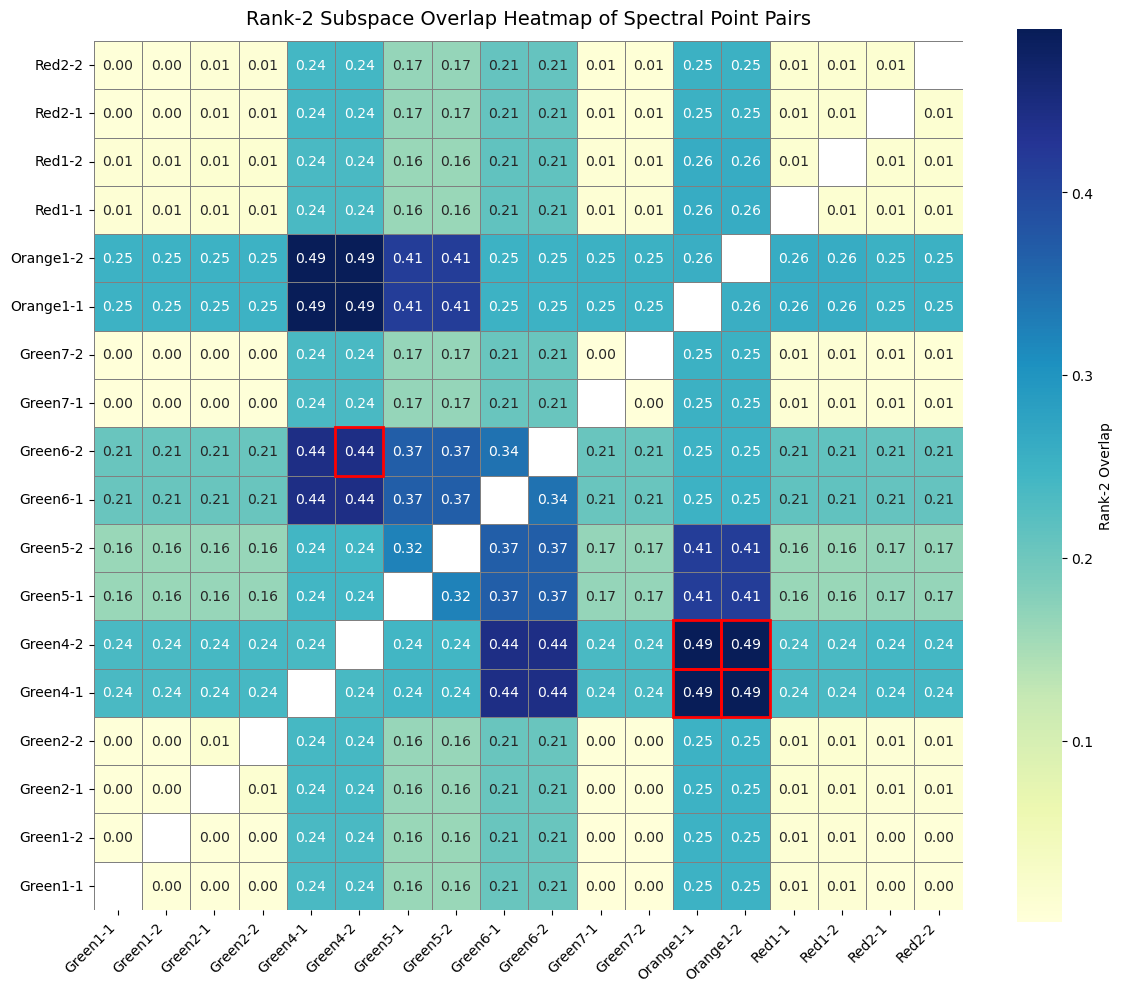

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 假设你已有 df_rank2，其中包含：
# - "ComboLabel": e.g. "Green2-1 + Red2-2"
# - "Rank2_Overlap_q": 数值

# === Step 1: 提取所有唯一的点名 ===
all_labels = sorted(set(sum([label.split(' + ') for label in df_rank2['ComboLabel']], [])))

# 创建空的对称矩阵
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# 填入值
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# 对角线设置为 NaN（不绘制）
np.fill_diagonal(heatmap_matrix.values, np.nan)

# === Step 2: 找出 Top-5 的组合 ===
top5 = df_rank2.nlargest(5, 'Rank2_Overlap_q')

# === Step 3: 绘制热力图 ===
plt.figure(figsize=(12, 10))
ax = sns.heatmap(heatmap_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True,
                 cbar_kws={'label': 'Rank-2 Overlap'}, linewidths=0.5, linecolor='gray')

# 标题设置
plt.title("Rank-2 Subspace Overlap Heatmap of Spectral Point Pairs", fontsize=14, pad=12)

# === Step 4: 添加红框标记 Top-5 ===
for _, row in top5.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    i = all_labels.index(a)
    j = all_labels.index(b)
    # 因为是对称的，可以只画一次
    rect = Rectangle((j, i), 1, 1, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

# 坐标轴标签旋转
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax.invert_yaxis()  # ✅ 反转纵轴以符合学术规范

# 紧凑布局
plt.tight_layout()
plt.show()


In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# === Step 1: 构建矩阵 ===
all_labels = sorted(set(df_rank2['ComboLabel']))
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

for _, row in df_rank2.iterrows():
    label = row['Label']
    heatmap_matrix.loc[label, label] = row['Overlap_q']

# === Step 2: 构造 mask 和 annot ===
mask_rank1 = ~np.eye(len(all_labels), dtype=bool)
mask_rank2 = np.eye(len(all_labels), dtype=bool)

annot_matrix_rank1 = heatmap_matrix.where(~mask_rank1).round(2).astype(str).mask(mask_rank1, "")
annot_matrix_rank2 = heatmap_matrix.where(~mask_rank2).round(2).astype(str).mask(mask_rank2, "")

# === Step 3: 自定义 colormap ===
# 蓝色渐变（Rank-2）
cmap_rank2 = LinearSegmentedColormap.from_list("bright_blue_gradient", [
    "#D6ECFF",  # 极浅蓝（几乎白蓝过渡）
    "#89CFF0",  # 宝宝蓝（清新专业）
    "#4CA5D9",  # 主体蓝色（明亮）
    "#2171B5",  # 稍深蓝
    "#08306B"   # 压轴深蓝
])

# 色值列表从浅到深（棕色系）
cmap_rank1 = LinearSegmentedColormap.from_list("custom_rank1_softbrown", [
    "#F5E5C6",  # 浅奶茶
    "#EBD0A4",  # 米杏色
    "#D7BD92",  # 金棕色（中等）
    "#B99876",  # 柔和深杏
    "#8C6D4E"   # 稍暗但不沉
])

# === Step 4: 色阶范围 ===
rank1_values = heatmap_matrix.values[np.eye(len(all_labels), dtype=bool)]
rank2_values = heatmap_matrix.values[~np.eye(len(all_labels), dtype=bool)]

rank1_min, rank1_max = np.nanmin(rank1_values), np.nanmax(rank1_values)
rank2_min, rank2_max = np.nanmin(rank2_values), np.nanmax(rank2_values)

# === Step 5: 白/黑字体判断函数 ===
def get_text_color(value, cmap, vmin, vmax):
    """根据背景亮度自动设置文字为黑色或白色"""
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

# === Step 6: 绘图 ===
fig, ax = plt.subplots(figsize=(9, 8))

# 绘制背景蓝色（rank-2）
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank2,
    cmap=cmap_rank2,
    annot=False,
    fmt="",
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# 绘制背景橙色（rank-1）
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank1,
    cmap=cmap_rank1,
    annot=False,
    fmt="",
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# 添加数值文字（自动字体颜色）
for i in range(len(all_labels)):
    for j in range(len(all_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                ha='center', va='center', color=color, fontsize=8)

# === Step 7: 添加双色条 ===
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)

sm1 = ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max))
sm1.set_array([])
fig.colorbar(sm1, cax=cax1)

sm2 = ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max))
sm2.set_array([])
fig.colorbar(sm2, cax=cax2)

# === Step 8: 美化 ===

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


KeyError: 'Label'

In [ ]:
# 选择谱圆内的特征值中实部最大的前4个作为绿点
eigvals_inside = [z for z in eigvals_np if abs(z) <= R and abs(z.imag) < 1e-6]  # 实数点且在谱圆内
eigvals_inside_sorted = sorted(eigvals_inside, key=lambda z: z.real, reverse=True)
green_vals = eigvals_inside_sorted[:4]  # 取前4个最大实部

# 绘图
if len(green_vals) > 0:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
                color="green", s=30, label="Internal Drifters")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


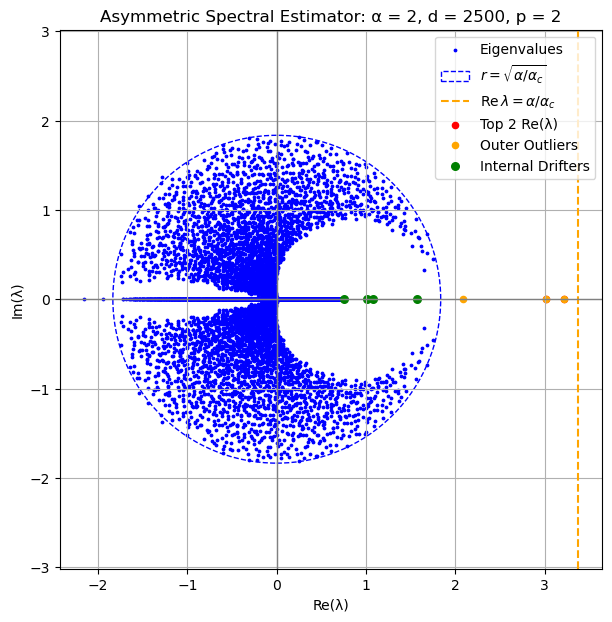

       Type      λ (eigval)  Alignment Score
0     Red-1  3.0193+0.0000j           0.4110
1     Red-2  3.2140+0.0000j           0.4033
2  Orange-1  3.2140+0.0000j           0.4033
3  Orange-2  3.0193+0.0000j           0.4110
4  Orange-3  2.0886+0.0000j           0.0254
5   Green-1  1.5655+0.0000j           0.0243
6   Green-2  1.0752+0.0000j           0.2885
7   Green-3  1.0114+0.0000j           0.2554
8   Green-4  0.7472+0.0000j           0.0784


In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# ========== Alignment 评估函数 ==========
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# ========== 重写子空间提取与对齐函数 ==========
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    """
    提取对应谱值的特征向量，映射回 d 维，计算对齐度。
    """
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]          # shape: (n*p,)
    V = v_hat.reshape(-1, p)            # shape: (n, p)
    U = (X.cpu().numpy().T) @ V         # shape: (d, p)
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# ========== 特征值与特征向量提取 ==========
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# === 阈值定义 ===
R = np.sqrt(alpha / alpha_c)        # 蓝色圆圈半径
thresh_ext = alpha / alpha_c        # 橙色虚线位置

# 筛选实数特征值
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# 红色：前两个最大 Re(λ)
red_vals = eigvals_real_only[np.argsort(real_parts)[-2:]]

# 橙色：实部 > alpha/alpha_c 的 outliers（根据定义筛选）
orange_vals = [val for val in eigvals_real_only if val.real > R]

# 绿色：实部 < R 的点中，实部最大前两个
green_candidates = [val for val in eigvals_real_only if val.real < R]
green_vals = sorted(green_candidates, key=lambda z: -z.real)[:4]

# ========== 可视化 ==========
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# 红点
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=20, label="Top 2 Re(λ)")

# 橙点
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
            color="orange", s=20, label="Outer Outliers")

# 绿点（前两个圈内最大实部点）
if len(green_vals) > 0:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
                color="green", s=30, label="Internal Drifters")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# ========== Alignment 结果输出 ==========
results = []

# 红点
for i, val in enumerate(red_vals):
    label = f"Red-{i+1}"
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=label))

# 橙点
for i, val in enumerate(orange_vals):
    label = f"Orange-{i+1}"
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=label))

# 绿点（最多两个）
for i, val in enumerate(green_vals):
    label = f"Green-{i+1}"
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=label))

# ========== 表格展示 ==========
df = pd.DataFrame(results, columns=["Type", "λ (eigval)", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df)


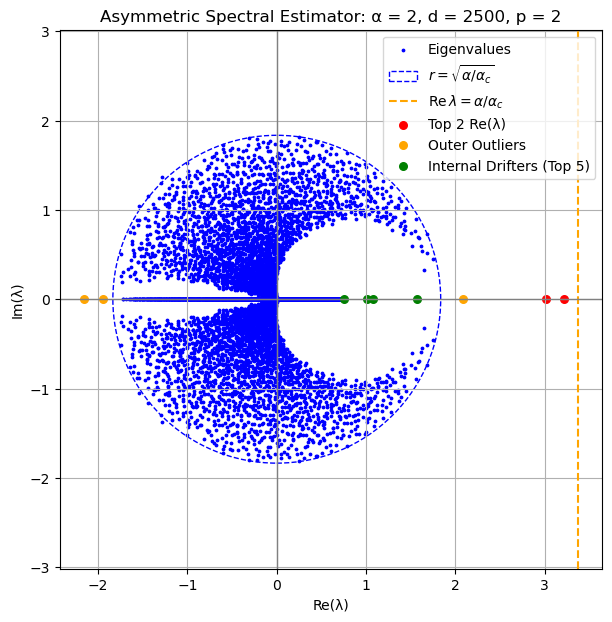

       Type      λ (eigval)  Alignment Score
0     Red-1  3.2140+0.0000j           0.4033
1     Red-2  3.0193+0.0000j           0.4110
2  Orange-1 -2.1536+0.0000j           0.0207
3  Orange-2 -1.9407+0.0000j           0.0191
4  Orange-3  2.0886+0.0000j           0.0254
5   Green-1  1.5655+0.0000j           0.0243
6   Green-2  1.0752+0.0000j           0.2885
7   Green-3  1.0114+0.0000j           0.2554
8   Green-4  0.7472+0.0000j           0.0784


In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# ========== Alignment 评估函数 ==========
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# ========== 子空间提取与对齐 ==========
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# ========== 特征值与特征向量提取 ==========
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# === 参数定义 ===
R = np.sqrt(alpha / alpha_c)          # 圆圈半径
thresh_ext = alpha / alpha_c          # 虚线阈值

# === 仅保留实数特征值 ===
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

# === 红色点：前两个最大实部点 ===
red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]

# === 橙色点：在圆圈外，且不在红点中 ===
orange_candidates = [z for z in eigvals_real_only if abs(z) > R]
orange_vals = [z for z in orange_candidates if z not in red_vals]

# === 绿色点：在圆圈内的最大实部前5个 ===
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:4]

# ========== 可视化 ==========
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# 红点
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=30, label="Top 2 Re(λ)")

# 橙点
if orange_vals:
    plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
                color="orange", s=30, label="Outer Outliers")

# 绿点
if green_vals:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
                color="green", s=30, label="Internal Drifters (Top 5)")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# ========== Alignment 分析 ==========
results = []

for i, val in enumerate(red_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Red-{i+1}"))

for i, val in enumerate(orange_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Orange-{i+1}"))

for i, val in enumerate(green_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Green-{i+1}"))

# ========== 输出表格 ==========
df = pd.DataFrame(results, columns=["Type", "λ (eigval)", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df)
